In [38]:
# env: sex_diff
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from scipy.interpolate import UnivariateSpline

## (1) Distribution of lifespan dataset 

In [ ]:
Mencoded500= scipy.io.loadmat("/LS3/krakenLS3dyn403_1419subj_20250327_152011_ep000500_encoded.mat",simplify_cells=True)
Msplit= scipy.io.loadmat("/LS3/ls3_subject_splits_1419subj_403train_45val_838test_1286balanced.mat",simplify_cells=True)
demograph = pd.read_csv("/LS3/ls3_subjinfo_agesexcog_details_1419subj.csv")

Xfus=Mencoded500['predicted_alltypes']['fusion']['encoded'] #1419 x 128
Xfus_train=Xfus[Msplit['subjidx_train'],:] #403 x 128
Xfus_val=Xfus[Msplit['subjidx_val'],:] #45 x 128
Xfus_test=Xfus[Msplit['subjidx_test'],:] #838 x 128

demograph['sex_index'] = demograph['sex']
demograph.loc[demograph['sex_index'] == 'M', 'sex_index']=1
demograph.loc[demograph['sex_index'] == 'F', 'sex_index']=0

demograph_train = demograph.iloc[Msplit['subjidx_train']][['sex_index', 'age', 'subjectid', 'Site', 'study']]
demograph_val = demograph.iloc[Msplit['subjidx_val']][['sex_index', 'age', 'subjectid', 'Site', 'study']]
demograph_test = demograph.iloc[Msplit['subjidx_test']][['sex_index', 'age', 'subjectid', 'Site', 'study']]
demograph_val_test = pd.concat([demograph_val, demograph_test])
combined1286 = pd.concat([demograph_train, demograph_val, demograph_test])

### (i) Distribution of age, sex

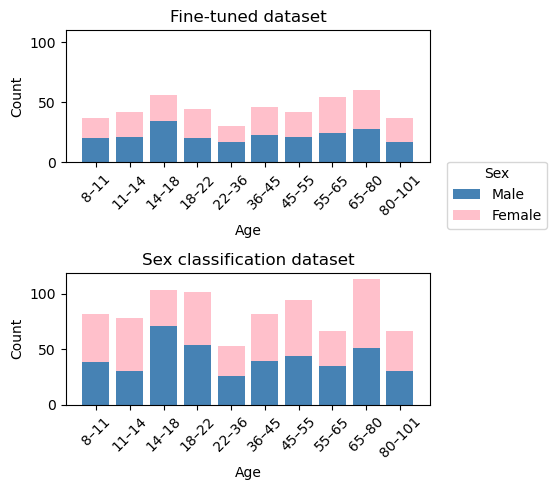

In [13]:
bins = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]
def count_sex_by_bin(df, bins):
    df['age_category'] = pd.cut(df['age'], bins=bins, right=False)
    counts = df.groupby(['age_category', 'sex_index'], observed=True).size().unstack(fill_value=0)
    return counts

combined_train_val = pd.concat([demograph_train, demograph_val])
counts_train_val = count_sex_by_bin(combined_train_val, bins)

# Test set for second plot
counts_test = count_sex_by_bin(demograph_test, bins)

fig, axes = plt.subplots(2, 1, figsize=(5, 5))
age_labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]
x = np.arange(len(age_labels))

# Train + Val plot
bar1 = axes[0].bar(x, counts_train_val[1], label='Male', color='steelblue')
bar2 = axes[0].bar(x, counts_train_val[0], bottom=counts_train_val[1], label='Female', color='pink')
axes[0].set_xticks(x)
axes[0].set_xticklabels(age_labels, rotation=45)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].set_title('Fine-tuned dataset')
axes[0].set_ylim(0, 110)
#axes[0].legend()

# Test plot
axes[1].bar(x, counts_test[1], color='steelblue')
axes[1].bar(x, counts_test[0], bottom=counts_test[1], color='pink')
axes[1].set_xticks(x)
axes[1].set_xticklabels(age_labels, rotation=45)
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')
axes[1].set_title('Sex classification dataset')
axes[0].set_ylim(0, 110)

#axes[1].legend()

# Shared legend on the left
fig.legend([bar1, bar2], ['Male', 'Female'], loc='center left', bbox_to_anchor=(0.99, 0.6), title="Sex")

plt.tight_layout(rect=[0.1, 0, 1, 1])
plt.show()

### (ii) Distribution of site

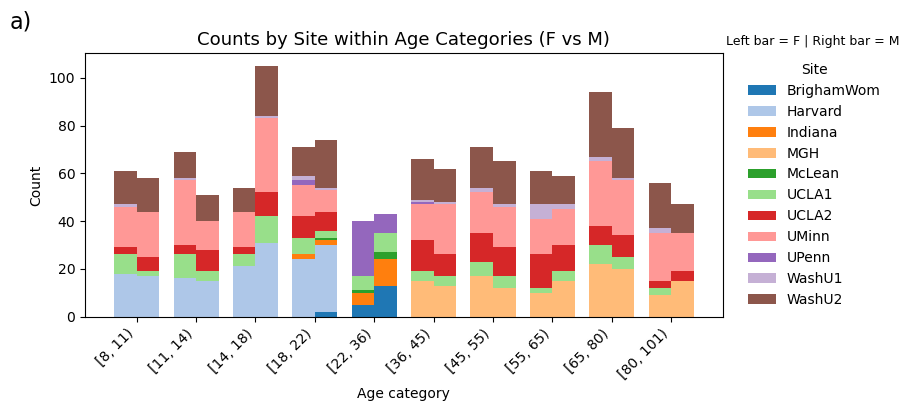

In [ ]:
df = combined1286.copy()
bins = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]
df['age_category'] = pd.cut(df['age'], bins=bins, right=False)
counts = df.groupby(['age_category', 'Site'], observed=True).size().unstack(fill_value=0)

# --- Aggregate raw counts (no proportions) ---
pivot = (df.groupby(['age_category', 'sex_index', 'Site'], observed=True)
           .size().rename('count').reset_index())

age_bins = df['age_category'].cat.categories
sites = sorted(pivot['Site'].unique())
sex_order = [0, 1]  # adjust if your values differ

def counts_for(sex):
    sub = pivot[pivot['sex_index'] == sex]
    tbl = (sub.pivot(index='age_category', columns='Site', values='count')
             .reindex(index=age_bins, columns=sites)
             .fillna(0))
    return tbl

counts_F = counts_for(sex_order[0])
counts_M = counts_for(sex_order[1])

# --- Plot two stacked bars (counts) per bin: left=Female, right=Male ---
x = np.arange(len(age_bins))
bar_w = 0.38
fig, ax = plt.subplots(figsize=(9, 4))

cmap = plt.get_cmap('tab20')
colors = [cmap(i % cmap.N) for i in range(len(sites))]

bottom_F = np.zeros(len(age_bins))
bottom_M = np.zeros(len(age_bins))

for i, site in enumerate(sites):
    ax.bar(x - bar_w/2, counts_F[site].values, bar_w, bottom=bottom_F, color=colors[i])
    ax.bar(x + bar_w/2, counts_M[site].values, bar_w, bottom=bottom_M, color=colors[i])
    bottom_F += counts_F[site].values
    bottom_M += counts_M[site].values

# Axis formatting (counts on y-axis)
ax.set_xticks(x)
ax.set_xticklabels([f"[{iv.left}, {iv.right})" for iv in age_bins], rotation=45, ha='right')
ax.set_xlabel("Age category")
ax.set_ylabel("Count")
ax.set_title("Counts by Site within Age Categories (F vs M)", fontsize = 13)

# Legend outside
handles = [Patch(facecolor=colors[i], label=str(s)) for i, s in enumerate(sites)]
ax.legend(handles=handles, title="Site", loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
fig.subplots_adjust(right=0.8)

# Small note for clarity
ax.text(1.005, 1.02, f"Left bar = F | Right bar = M", transform=ax.transAxes, ha='left', va='bottom', fontsize=9)
fig.text(0.02, 0.97, "a)", fontsize=16, ha='right')   
plt.tight_layout()
plt.show()

### (iii) Distribution of meanFD

In [ ]:
df_fwd = pd.read_csv('/home/keh4016/HCP_data/LS3/ls3_scan_nonoutlier_fd_dvars_1419subj.tsv', sep='\t')
df_mfwd = df_fwd[['subject', 'fd_power']].groupby('subject').mean()
df_merged =  df.merge(df_mfwd, left_on="subjectid", right_on="subject",how="left")

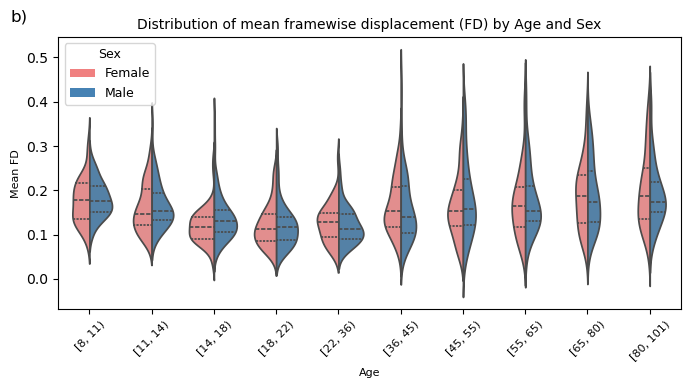

In [ ]:
import seaborn as sns
plt.figure(figsize=(7, 4))
sns.violinplot(x='age_category', y='fd_power', hue='sex_index', data=df_merged, split=True,
                inner='quartile', palette={0: "lightcoral", 1: "steelblue"})
plt.title('Distribution of mean framewise displacement (FD) by Age and Sex', fontsize=10)
plt.xlabel("Age", fontsize=8)
plt.ylabel("Mean FD", fontsize=8)
plt.xticks(rotation=45, fontsize=8)

# Custom legend with solid colors
handles = [
    Patch(facecolor="lightcoral", label="Female"),
    Patch(facecolor="steelblue", label="Male")
]
plt.legend(handles=handles, title="Sex", fontsize=9, title_fontsize=9)
plt.text(-1, 0.58, "b)", fontsize=12, ha='right')   
plt.tight_layout()
plt.show()

#### permutation test to compare meanFD

In [20]:
#### mean_fd different or not across groups
from scipy.stats import permutation_test
from statsmodels.stats.multitest import multipletests

def pairwise_permutation_fdr(df, group_col, value_col,
                             n_resamples=1000, alternative='two-sided', alpha=0.05):

    groups = df[group_col].unique()
    groups_sorted = sorted(groups)
    results = []

    # Generate all group pairs (i < j)
    for i in [6]: #range(len(groups_sorted)):
        #for j in range(i+1, len(groups_sorted)):
        for j in range(len(groups_sorted)):
            if j == i:
                continue
            g1, g2 = groups_sorted[i], groups_sorted[j]

            x = df[df[group_col] == g1][value_col].values
            y = df[df[group_col] == g2][value_col].values

            # Define the statistic: difference in means
            stat_func = lambda a, b: np.mean(a) - np.mean(b)
            res = permutation_test(
                (x, y),
                statistic=stat_func,
                n_resamples=n_resamples,
                alternative=alternative
            )

            pvalue = res.pvalue

            results.append([g1, g2,
                            x.mean(), y.mean(),
                            y.mean() - x.mean(),
                            pvalue])

    # Make DataFrame
    res_df = pd.DataFrame(results,
                          columns=['group1', 'group2',
                                   'mean_g1', 'mean_g2', 'mean_diff',
                                   'p_perm'])

    # FDR (BH)
    res_df['p_fdr'] = multipletests(res_df['p_perm'], method='fdr_bh')[1]
    res_df['reject_fdr'] = res_df['p_fdr'] < alpha

    return res_df

In [22]:
pairwise_permutation_fdr(df_merged, 'age_category', 'fd_power', n_resamples=10000, alternative='two-sided', alpha=0.05)

,group1,group2,mean_g1,mean_g2,mean_diff,p_perm,p_fdr,reject_fdr
0,"[45, 55)","[8, 11)",0.17172,0.177802,0.006082,0.465153,0.523298,False
1,"[45, 55)","[11, 14)",0.17172,0.163199,-0.008520,0.308769,0.440442,False
2,"[45, 55)","[14, 18)",0.17172,0.133241,-0.038478,0.000200,0.000600,True
3,"[45, 55)","[18, 22)",0.17172,0.122012,-0.049708,0.000200,0.000600,True
4,"[45, 55)","[22, 36)",0.17172,0.123978,-0.047741,0.000200,0.000600,True
5,"[45, 55)","[36, 45)",0.17172,0.162941,-0.008779,0.342566,0.440442,False
6,"[45, 55)","[55, 65)",0.17172,0.176962,0.005243,0.602740,0.602740,False
7,"[45, 55)","[65, 80)",0.17172,0.190419,0.018700,0.042996,0.077392,False
8,"[45, 55)","[80, 101)",0.17172,0.197094,0.025374,0.013799,0.031047,True


In [25]:
#### mean_fd different or not between sexes within age groups
def sex_permutation_by_group(df, group_col, value_col,
                             sex_col='sex_index',
                             n_resamples=10000,
                             alternative='two-sided',
                             alpha=0.05):

    groups = sorted(df[group_col].unique())
    results = []

    for g in groups:
        sub = df[df[group_col] == g]
        x = sub[sub[sex_col] == 0][value_col].to_numpy()  
        y = sub[sub[sex_col] == 1][value_col].to_numpy() 

        if len(x) == 0 or len(y) == 0:
            continue  # skip if group missing one sex

        stat_func = lambda a, b: np.mean(a) - np.mean(b)

        res = permutation_test(
            (x, y),
            statistic=stat_func,
            n_resamples=n_resamples,
            alternative=alternative,
            vectorized=False
        )

        results.append([
            g,
            np.mean(x), np.mean(y),
            np.mean(x) - np.mean(y),
            res.statistic, res.pvalue
        ])

    res_df = pd.DataFrame(
        results,
        columns=["age_group", "mean_female", "mean_male",
                 "mean_diff_female_minus_male",
                 "perm_stat", "p_raw"]
    )

    # FDR correction across age groups
    res_df["p_fdr"] = multipletests(res_df["p_raw"], method="fdr_bh")[1]
    res_df["reject_fdr"] = res_df["p_fdr"] < alpha

    return res_df

In [26]:
sex_permutation_by_group(df_merged, 'age_category', 'fd_power')

,age_group,mean_female,mean_male,mean_diff_female_minus_male,perm_stat,p_raw,p_fdr,reject_fdr
0,"[8, 11)",0.175363,0.180367,-0.005004,-0.005004,0.556944,0.917158,False
1,"[11, 14)",0.160288,0.167137,-0.006849,-0.006849,0.479952,0.917158,False
2,"[14, 18)",0.120388,0.139851,-0.019463,-0.019463,0.019198,0.191981,False
3,"[18, 22)",0.121359,0.122638,-0.001279,-0.001279,0.881512,0.979458,False
4,"[22, 36)",0.127587,0.120621,0.006966,0.006966,0.445355,0.917158,False
5,"[36, 45)",0.165266,0.160466,0.004800,0.004800,0.705929,0.917158,False
6,"[45, 55)",0.161584,0.182790,-0.021206,-0.021206,0.126987,0.634937,False
7,"[55, 65)",0.174635,0.179368,-0.004732,-0.004732,0.733727,0.917158,False
8,"[65, 80)",0.190213,0.190665,-0.000452,-0.000452,0.979702,0.979702,False
9,"[80, 101)",0.202240,0.190962,0.011278,0.011278,0.477152,0.917158,False


## (2) PCA of latent space (Krakencoder; sex fine-tuned Krakencoder)

In [ ]:
Mencoded500= scipy.io.loadmat("/LS3/krakenLS3dyn403_1419subj_20250327_152011_ep000500_encoded.mat",simplify_cells=True)
Msplit= scipy.io.loadmat("/LS3/ls3_subject_splits_1419subj_403train_45val_838test_1286balanced.mat",simplify_cells=True)
demograph = pd.read_csv("/LS3/ls3_subjinfo_agesexcog_details_1419subj.csv")

Xfus=Mencoded500['predicted_alltypes']['fusion']['encoded'] #1419 x 128
Xfus_train=Xfus[Msplit['subjidx_train'],:] #403 x 128
Xfus_val=Xfus[Msplit['subjidx_val'],:] #45 x 128
Xfus_test=Xfus[Msplit['subjidx_test'],:] #838 x 128

demograph['sex_index'] = demograph['sex']
demograph.loc[demograph['sex_index'] == 'M', 'sex_index']=1
demograph.loc[demograph['sex_index'] == 'F', 'sex_index']=0

demograph_train = demograph.iloc[Msplit['subjidx_train']][['sex_index', 'age', 'subjectid', 'Site', 'study']]
demograph_val = demograph.iloc[Msplit['subjidx_val']][['sex_index', 'age', 'subjectid', 'Site', 'study']]
demograph_test = demograph.iloc[Msplit['subjidx_test']][['sex_index', 'age', 'subjectid', 'Site', 'study']]
demograph_val_test = pd.concat([demograph_val, demograph_test])

In [ ]:
def loadmat(filename):
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

kr_sex = loadmat(f'/LS3/krakenLS3dynICV403demofineSEX100_20251107_144040_ep000500_encoded.mat')
kr_orig = loadmat(f'/LS3/ls3_adapt403_dynseedICV_20240413_210723_ep002000_encoded.mat')
kr_sex_encoded = kr_sex['predicted_alltypes']['fusion']['encoded']
kr_orig_encoded = kr_orig['predicted_alltypes']['fusion']['encoded']

In [34]:
kr_sex_test = kr_sex_encoded[Msplit['subjidx_test'],:]
kr_sex_val = kr_sex_encoded[Msplit['subjidx_val'],:]

kr_orig_test = kr_orig_encoded[Msplit['subjidx_test'],:]
kr_orig_val = kr_orig_encoded[Msplit['subjidx_val'],:]

kr_sex_classify = np.concatenate([kr_sex_val, kr_sex_test])
kr_orig_classify = np.concatenate([kr_orig_val, kr_orig_test])

/tmp/ipykernel_3970620/88113728.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


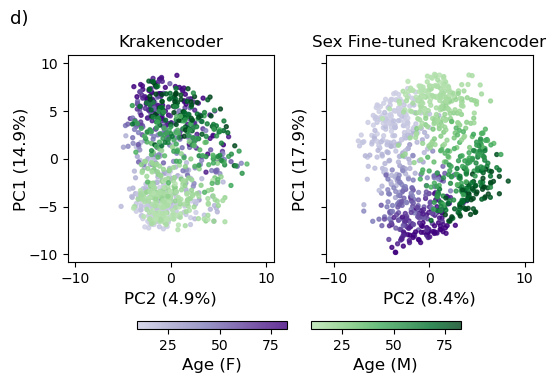

In [39]:
X_sex  = kr_sex_classify     # shape (883, 128)
X_orig = kr_orig_classify    # shape (883, 128)

age_classify = demograph_val_test['age'].values
sex_classify = demograph_val_test['sex_index'].values

def truncate_colormap(cmap_name, minval=0.0, maxval=1.0, n=256):
    cmap = cm.get_cmap(cmap_name)
    new_colors = cmap(np.linspace(minval, maxval, n))
    return LinearSegmentedColormap.from_list(
        f"trunc({cmap_name},{minval:.2f},{maxval:.2f})",
        new_colors
    )

def pca2(X):
    Xz = StandardScaler().fit_transform(X)
    return PCA(n_components=2, random_state=0).fit_transform(Xz)

Z_sex  = pca2(kr_sex_classify)
Z_orig = pca2(kr_orig_classify)

age = np.asarray(age_classify)
sex = np.asarray(sex_classify).astype(int)  # 0=female, 1=male

norm = Normalize(vmin=np.percentile(age, 5),
                 vmax=np.percentile(age, 95))

cmap_f = truncate_colormap("Purples",   minval=0.3, maxval=1.0)
cmap_m = truncate_colormap("Greens", minval=0.3, maxval=1.0)

all_Z = np.vstack([Z_orig, Z_sex])
lim = np.max(np.abs(all_Z))+1

# Explained variance for each dataset
# Original Krakencoder: PC1: 14.9%, PC2: 4.9%
# Sex Fine-tuned Krakencoder: PC1: 17.9%, PC2: 8.4%
var_explained = {
    'Krakencoder': {'PC1': 14.9, 'PC2': 4.9},
    'Sex Fine-tuned Krakencoder': {'PC1': 17.9, 'PC2': 8.4}
}

fig, axs = plt.subplots(1, 2, figsize=(6, 5), sharex=True, sharey=True, gridspec_kw={"wspace": 0.25})

# ---- main plots ----
for idx, (ax, Z, title) in enumerate(zip(axs, [Z_orig, Z_sex], ["Krakencoder", "Sex Fine-tuned Krakencoder"])):
    ax.set_aspect("equal", adjustable="box")
    mf = (sex == 0)
    mm = (sex == 1)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    sc_f = ax.scatter(Z[mf, 1], Z[mf, 0],
                      c=age[mf], cmap=cmap_f, norm=norm,
                      s=8, alpha=0.8, marker="o")

    sc_m = ax.scatter(Z[mm, 1], Z[mm, 0],
                      c=age[mm], cmap=cmap_m, norm=norm,
                      s=8, alpha=0.8, marker="o")

    ax.set_title(title, fontsize = 12)
    
    # Add explained variance to axis labels
    pc1_var = var_explained[title]['PC1']
    pc2_var = var_explained[title]['PC2']
    ax.set_xlabel(f"PC2 ({pc2_var}%)", fontsize = 12)
    
    # Use different labelpad for second plot
    labelpad_val = 0 if idx == 0 else 10
    ax.set_ylabel(f"PC1 ({pc1_var}%)", fontsize = 12, labelpad=labelpad_val)

plt.subplots_adjust(bottom=0.18)

cax_f = fig.add_axes([0.24, 0.19, 0.25, 0.015])  # left bar
cax_m = fig.add_axes([0.53, 0.19, 0.25, 0.015])  # right bar

cb_f = fig.colorbar(sc_f, cax=cax_f, orientation="horizontal")
cb_f.set_label("Age (F)", fontsize=12)
cb_f.ax.tick_params(labelsize=10)

cb_m = fig.colorbar(sc_m, cax=cax_m, orientation="horizontal")
cb_m.set_label("Age (M)", fontsize=12)
cb_m.ax.tick_params(labelsize=10)

fig.text(0.06, 0.8, "d)", fontsize=13, ha='right')   
plt.show()

In [40]:
Xz = StandardScaler().fit_transform(kr_sex_classify)
# get explained variance of latent space (sex fine-tuned Krakencoder)
pca = PCA(random_state=0)
pca.fit(Xz)
explained_variance = pca.explained_variance_ratio_
explained_variance[:2]

array([0.17888607, 0.0837104 ], dtype=float32)

In [41]:
Xz = StandardScaler().fit_transform(kr_orig_classify)
# get explained variance of latent space (original Krakencoder)
pca = PCA(random_state=0)
pca.fit(Xz)
explained_variance = pca.explained_variance_ratio_
explained_variance[:2]

array([0.1493416, 0.0489617], dtype=float32)

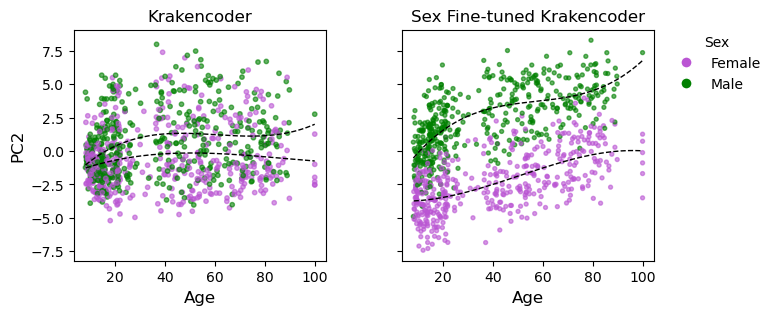

In [42]:
pc2_orig = Z_orig[:, 1]  # PC2 for original Krakencoder
pc2_sex  = Z_sex[:, 1]   # PC2 for sex fine-tuned Krakencoder

# Colors: 0=female, 1=male
colors = ['mediumorchid', 'green']
sex_colors = [colors[int(s)] for s in sex]

def add_spline(ax, x, y, color, s_factor=0.5, n_grid=200, lw=1):
    """
    Fit and plot a smoothing spline y ~ f(x).
    """
    x = np.asarray(x).astype(float)
    y = np.asarray(y).astype(float)

    # drop NaNs
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]

    # need enough points
    if len(x) < 10:
        return

    # sort by x
    idx = np.argsort(x)
    x, y = x[idx], y[idx]

    # smoothing parameter: scale by sample size and variance for stability
    s = s_factor * len(x) * np.var(y)

    spline = UnivariateSpline(x, y, k=3, s=s)
    xg = np.linspace(x.min(), x.max(), n_grid)
    ax.plot(xg, spline(xg), color=color, lw=lw, linestyle='--')

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True, gridspec_kw={"wspace": 0.3})

# Scatter plots
ax[0].scatter(age, pc2_orig, c=sex_colors, alpha=0.6, s=10)
ax[0].set_title("Krakencoder", fontsize=12)
ax[0].set_xlabel("Age", fontsize=12)
ax[0].set_ylabel("PC2", fontsize=12)

ax[1].scatter(age, pc2_sex, c=sex_colors, alpha=0.6, s=8)
ax[1].set_title("Sex Fine-tuned Krakencoder", fontsize=12)
ax[1].set_xlabel("Age", fontsize=12)

# Add splines per sex for each subplot
for s_val, col in [(0, 'mediumorchid'), (1, 'green')]:
    mask = (np.asarray(sex).astype(int) == s_val)
    add_spline(ax[0], np.asarray(age)[mask], np.asarray(pc2_orig)[mask], color='black', s_factor=1)
    add_spline(ax[1], np.asarray(age)[mask], np.asarray(pc2_sex)[mask],  color='black', s_factor=1)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='mediumorchid', markersize=8, label='Female'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Male')]
ax[1].legend(handles=legend_elements, title="Sex",
             loc="upper left", bbox_to_anchor=(1.05, 1),
             borderaxespad=0.0, frameon=False)
fig.subplots_adjust(right=0.85)
plt.show()